# **Correlation Analysis**

In [1]:
import os
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore", message="Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range")
warnings.filterwarnings("ignore", message="invalid value encountered in reduce")

import xarray as xr
import numpy as np
import scipy.signal as signal
import math
import pickle as pkl

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

import cmocean.cm as cmo

from PIL import Image

%load_ext autoreload
%autoreload 2
import hmei.processing as pcs
import hmei.visualization as vis

# Python Correlation Functions

**Documentation:**
* [numpy.correlate](https://numpy.org/doc/stable/reference/generated/numpy.correlate.html)
* [scipy.correlate](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.signal.correlate.html#scipy.signal.correlate)
* [scipy.correlation_lags](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.signal.correlation_lags.html#scipy.signal.correlation_lags)
* [matplotlib.pyplot.xcorr](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xcorr.html)

**Helpful Resources:**
* [Wikipedia - Cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation#Cross-correlation_of_stochastic_processes)
* [Wikipedia - Autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation)
* [Why are the results of R's ccf and SciPy's correlate different?](https://stats.stackexchange.com/questions/339782/why-are-the-results-of-rs-ccf-and-scipys-correlate-different/353408)
* [How do I get R's ccf in Python?](https://stackoverflow.com/questions/53959879/how-do-i-get-rs-ccf-in-python)
* [How to interpret the values returned by numpy.correlate and numpy.corrcoef?](https://stackoverflow.com/questions/13439718/how-to-interpret-the-values-returned-by-numpy-correlate-and-numpy-corrcoef)
* [**Oceanography Correlation Analysis**](https://currents.soest.hawaii.edu/ocn_data_analysis/_static/SEM_EDOF.html)
* [Penn State - Cross Correlation Functions and Lagged Regressions](https://online.stat.psu.edu/stat510/lesson/8/8.2)
* [Deterministic Skill Scores](https://metclim.ucd.ie/wp-content/uploads/2017/07/DeterministicSkillScore.pdf)

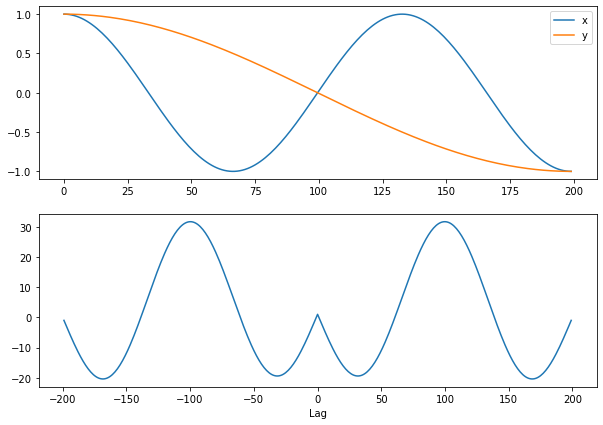

In [85]:
x = np.cos(np.linspace(0,np.pi*3,200))
y = np.cos(np.linspace(0,np.pi*1,200))

mode = 'full'
signal_corr = signal.correlate(x, y, mode=mode)
signal_lags = signal.correlation_lags(y.size, x.size, mode=mode)

fig, (ax_signals, ax_corr) = plt.subplots(2, 1, figsize=(10,7))

ax_signals.plot(x, label='x')
ax_signals.plot(y, label='y')
ax_signals.legend()

ax_corr.plot(signal_lags, signal_corr)

xlim = ax_corr.get_xlim()

ax_corr.set_xlabel('Lag');

In [65]:
## signal.correlate and np.correlate(mode='full') return the same arrays
## signal.correlate is faster for larger arrays
False in (signal.correlate(x,y) == np.correlate(x, y, mode='full'))

False

Text(0.5, 0, 'Lag')

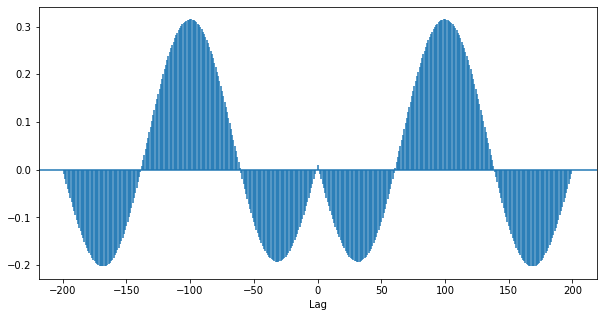

In [86]:
## matplotlib version of xcorr() which uses numpy.correlate(mode = 'full')
fig,ax = plt.subplots(figsize=(10,5))

plt_xcorr = ax.xcorr(x, y, maxlags=199, usevlines=True)
ax.set_xlabel('Lag')

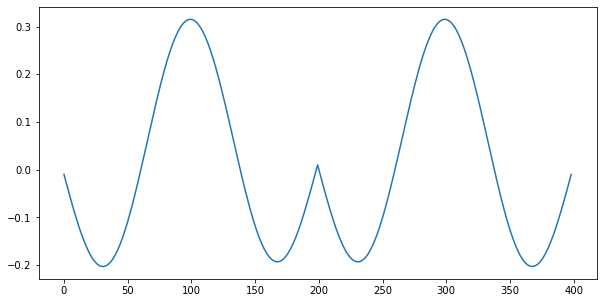

In [88]:
def ccf(x, y, lag_max = 199):

    result = signal.correlate(y - np.mean(y), x - np.mean(x)) / (np.std(y) * np.std(x) * len(y))
    length = (len(result) - 1) // 2
    lo = length - lag_max
    hi = length + (lag_max + 1)

    return result[lo:hi]

ccf = ccf(x,y)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(ccf)

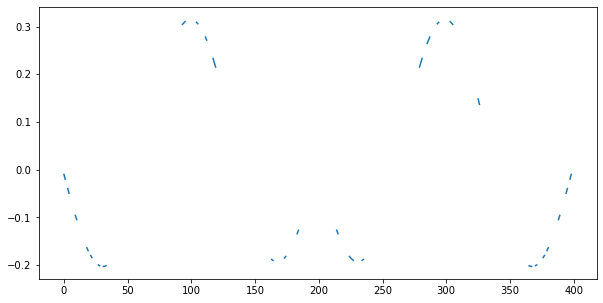

In [102]:
fig,ax = plt.subplots(figsize=(10,5))

ax.plot(np.where(ccf == plt_xcorr[1], ccf, np.nan))

In [2]:
def open_ppp(
    var, reg, timescale='monthly', ens_type=''):
    
    writedir = '/home/bbuchovecky/storage/so_predict_derived/'
    subdir = 'PPP/'+var.upper()+'/'
    if ens_type != '':
        ens_type += '_'
    filename = var.lower()+'_ts_'+reg+'_'+timescale+'_'+ens_type+'ppp.nc'
    return xr.open_dataset(writedir+subdir+filename)